In [1]:
from imblearn.over_sampling import SMOTE
import boto3
import sagemaker
from sagemaker.debugger import Rule, rule_configs
from sagemaker.tuner import(
    IntegerParameter,
    ContinuousParameter,
    HyperparameterTuner,
)
from sagemaker.inputs import TrainingInput
from sagemaker import get_execution_role
import pandas as pd

In [2]:
role = get_execution_role()
my_region = boto3.session.Session().region_name
print("Success - the MySageMakerInstance is in the " + my_region )
print(role)

Success - the MySageMakerInstance is in the ap-south-1
arn:aws:iam::570517415597:role/service-role/AmazonSageMaker-ExecutionRole-20210106T114090


In [3]:
sess = sagemaker.Session()
container = sagemaker.image_uris.retrieve("xgboost", my_region, "latest")
print(container)

991648021394.dkr.ecr.ap-south-1.amazonaws.com/xgboost:latest


In [4]:
#Replace bucket name with your bucket
my_bkt='mylaundrybucket'
rules=[Rule.sagemaker(rule_configs.create_xgboost_report())]
xgb = sagemaker.estimator.Estimator(
    container,
    role,
    instance_count=1,
    instance_type="ml.m4.xlarge",
    output_path='s3://{}/models'.format(my_bkt),
    sagemaker_session=sess,
)
xgb.set_hyperparameters(
    eval_metric="auc",
    objective="binary:logistic",
    num_round=100,
    rate_drop=0.3,
    tweedie_variance_power=1.4,
    rules=rules
)

In [5]:
s3_input_train = sagemaker.inputs.TrainingInput(s3_data='s3://{}/sage_train.csv'.format(my_bkt), content_type='csv')
s3_input_validation = sagemaker.inputs.TrainingInput(s3_data='s3://{}/sage_val.csv'.format(my_bkt), content_type='csv')

In [7]:
hyperparameter_ranges = {
    "eta": ContinuousParameter(0, 1),
    "min_child_weight": ContinuousParameter(1, 10),
    "alpha": ContinuousParameter(0, 2),
    "max_depth": IntegerParameter(4, 10),
}
objective_metric_name = "validation:auc"
tuner = HyperparameterTuner(xgb, objective_metric_name, hyperparameter_ranges, max_jobs=6, max_parallel_jobs=3)

In [8]:
tuner.fit({"train": s3_input_train, "validation": s3_input_validation}, include_cls_metadata=False)

...............................................................................................................!


In [9]:
from pprint import pprint
tuning_job_result=boto3.client("sagemaker").describe_hyper_parameter_tuning_job(
    HyperParameterTuningJobName=tuner.latest_tuning_job.job_name
)
if tuning_job_result.get("BestTrainingJob", None):
    print("Best model found so far:")
    pprint(tuning_job_result["BestTrainingJob"])
else:
    print("No training jobs have reported results yet.")

Best model found so far:
{'CreationTime': datetime.datetime(2022, 7, 2, 6, 2, 44, tzinfo=tzlocal()),
 'FinalHyperParameterTuningJobObjectiveMetric': {'MetricName': 'validation:auc',
                                                 'Value': 0.9948490262031555},
 'ObjectiveStatus': 'Succeeded',
 'TrainingEndTime': datetime.datetime(2022, 7, 2, 6, 6, 48, tzinfo=tzlocal()),
 'TrainingJobArn': 'arn:aws:sagemaker:ap-south-1:570517415597:training-job/xgboost-220702-0557-006-b02e145d',
 'TrainingJobName': 'xgboost-220702-0557-006-b02e145d',
 'TrainingJobStatus': 'Completed',
 'TrainingStartTime': datetime.datetime(2022, 7, 2, 6, 4, 25, tzinfo=tzlocal()),
 'TunedHyperParameters': {'alpha': '0.36843552580362204',
                          'eta': '0.3283748406816732',
                          'max_depth': '8',
                          'min_child_weight': '6.631353393968709'}}


In [13]:
my_best_job=tuning_job_result["BestTrainingJob"]["TrainingJobName"]

In [14]:
s3 = boto3.resource('s3')
bucket = s3.Bucket(my_bkt)
for obj in bucket.objects.all():
    if obj.key.find('model.tar')>-1:
        print(obj.key)
        KEY=obj.key

models/xgboost-220702-0557-001-7e933b22/output/model.tar.gz
models/xgboost-220702-0557-002-a50caa48/output/model.tar.gz
models/xgboost-220702-0557-003-8e680304/output/model.tar.gz
models/xgboost-220702-0557-004-d59193ca/output/model.tar.gz
models/xgboost-220702-0557-005-47391ac0/output/model.tar.gz
models/xgboost-220702-0557-006-b02e145d/output/model.tar.gz


In [15]:
my_best_job=tuning_job_result["BestTrainingJob"]["TrainingJobName"]
model = sagemaker.model.Model(
    image_uri=container,
    model_data='s3://{}/models/{}/output/model.tar.gz'.format(my_bkt,my_best_job),
    role=role)

transformer = model.transformer(
    instance_count=1, instance_type="ml.m5.xlarge", 
    assemble_with="Line", accept="text/csv",
    output_path='s3://{}/models'.format(my_bkt)
)

In [16]:
test_data_path='s3://{}/sage_test.csv'.format(my_bkt)
transformer.transform(test_data_path, content_type="text/csv") 

........................
Arguments: serve
Arguments: serve
[2022-07-02 06:18:27 +0000] [1] [INFO] Starting gunicorn 19.9.0
[2022-07-02 06:18:27 +0000] [1] [INFO] Listening at: http://0.0.0.0:8080 (1)
[2022-07-02 06:18:27 +0000] [1] [INFO] Using worker: gevent
[2022-07-02 06:18:27 +0000] [21] [INFO] Booting worker with pid: 21
[2022-07-02 06:18:27 +0000] [22] [INFO] Booting worker with pid: 22
[2022-07-02 06:18:27 +0000] [1] [INFO] Starting gunicorn 19.9.0
[2022-07-02 06:18:27 +0000] [1] [INFO] Listening at: http://0.0.0.0:8080 (1)
[2022-07-02 06:18:27 +0000] [1] [INFO] Using worker: gevent
[2022-07-02 06:18:27 +0000] [21] [INFO] Booting worker with pid: 21
[2022-07-02 06:18:27 +0000] [22] [INFO] Booting worker with pid: 22
[2022-07-02 06:18:27 +0000] [23] [INFO] Booting worker with pid: 23
/opt/amazon/lib/python3.7/site-packages/gunicorn/workers/ggevent.py:65: MonkeyPatchWarning: Monkey-patching ssl after ssl has already been imported may lead to errors, including RecursionError on Pyt

In [17]:
!aws s3 cp s3://mylaundrybucket/models/sage_test.csv.out output.csv
pred_proba = pd.read_csv('output.csv',header=None)
pred_proba

download: s3://mylaundrybucket/models/sage_test.csv.out to ./output.csv


,0
0,0.004634
1,0.999846
2,0.000608
3,0.969860
4,0.000032
...,...
8860,0.030168
8861,0.994613
8862,0.999929
8863,0.003643


In [22]:
s3.Bucket(my_bkt).download_file('Ground_Truth.csv', 'Ground_Truth.csv')
s3.Bucket(my_bkt).download_file('models/sage_test.csv.out', 'sage_test.csv.out')

In [24]:
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.metrics import plot_confusion_matrix,roc_curve,roc_auc_score,auc,confusion_matrix
import seaborn as sns

#Read in the downloaded files. pred_proba contains the predicted probabilities from our best model.
#The test_df comtains the ground truth data, with the first column containing the tru class labels.
pred_proba = pd.read_csv('output.csv',header=None)
test_df =pd.read_csv('Ground_Truth.csv',header=None)
y_test=test_df.iloc[:, 0].values

In [25]:
# Evaluate the metrics for various thresholds
fpr, tpr, thresholds = roc_curve(y_test,pred_proba)
# compute AUC
roc_auc = auc(fpr, tpr) 

Matplotlib is building the font cache; this may take a moment.


/home/ec2-user/anaconda3/envs/python3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


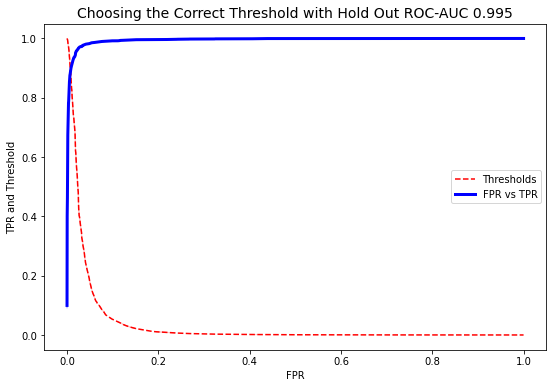

In [26]:
# Plotting the Threshold on the ROC Curve
fig = plt.figure(figsize=(9,6))

ax = fig.add_subplot(111)
ax.set_title('Choosing the Correct Threshold with Hold Out ROC-AUC {:0.3f}'.format(roc_auc), fontsize=14)
ax.set_ylabel('TPR and Threshold')
ax.set_xlabel('FPR')
 
# Plot the AUC Curve
ax=sns.lineplot(fpr[1::], thresholds[1::], markeredgecolor='r',linestyle='dashed', color='r',label='Thresholds')
# Plot the Thresholds Curve
ax=sns.lineplot(x=fpr[1::], y=tpr[1::],linewidth= 3,color='b',label='FPR vs TPR')